In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Mounted at /content/drive


((916, 10), (393, 10), (916,))

# Grid Search vs Random Search
- Random Search는 Grid Search에 비해 불필요한 반복 수행 횟수를 대폭 줄이면서 동시에 정해진 간격 사이에 위치한 값들에 대해서도 확률적으로 탐색이 가능하므로 최적 하이퍼파라미터 값을 더 빨리 찾을 수 있는 것으로 알려져 있음
- Grid Search와 Random Search는 이전까지의 탐색 과정에서 얻어진 하이퍼파라미터 조합의 성능 결과에 대한 사전 지식이 전혀 반영되어 있지 않기 때문에 비효율적인 요소가 있음


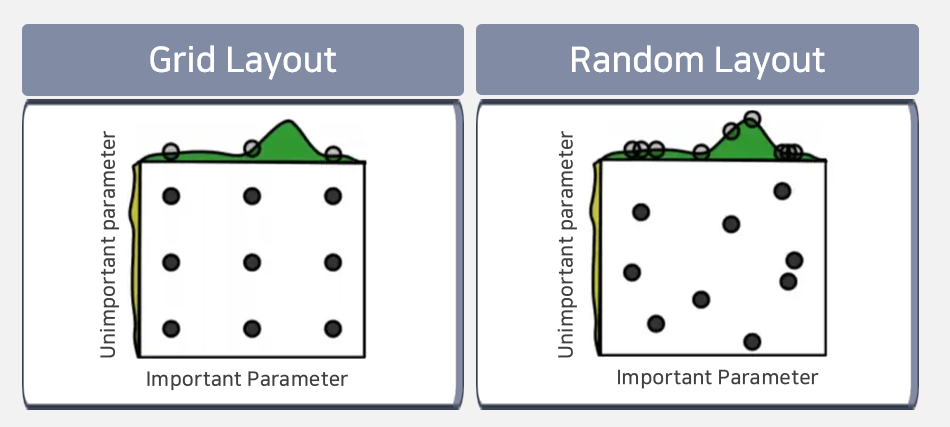

# Bayesian optimization
- 매 회 새로운 하이퍼파라미터 조합에 대한 조사를 수행할 경우 사전 지식을 충분히 반영하면서 전체적인 탐색 과정을 체계적으로 수행하는 튜닝 방법
- 미지의 목적 함수에 대하여 최대 또는 최소로 하는 반환 값을 만드는 최적 입력값을 탐색하는 방법
- 새로운 데이터를 입력 받았을 때 목적 함수를 근사화 하는 최적 함수를 추정하는 대체 모델을 개선해 나가면서 최적 함수를 만듦
- 대체 모델(Surrogate Model)
    - 획득 함수로부터 최적 함수를 추정할 수 있는 최적 입력값을  받아 이를 기반으로 최적 함수를 개선해 나가며 추정
- 획득 함수(Acquisition Function)
    - 개선된 대체 모델이 추정한 최적 함수에서 최적 입력값을 계산
- 베이지안 최적화를 이용한 하이퍼파라미터 튜닝을 적용할 수 있는
파이썬 라이브러리
    - Optuna, HyperOpt, Bayesian Optimization











## Bayesian optimization 튜닝 과정

- step1
    - 최초에는 랜덤하게 하이퍼파라미터들을 샘플링하여
성능 지표 결과값들을 관측

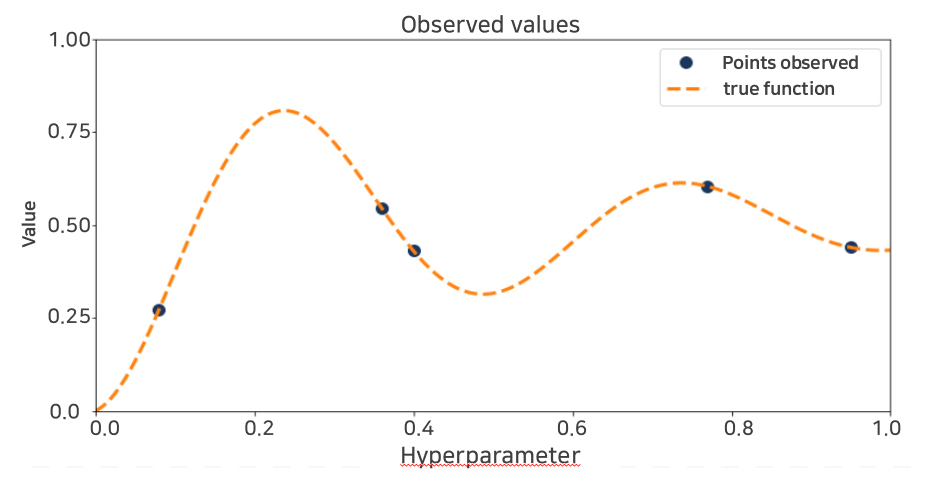

- step2
    - 관측된 데이터를 기반으로 대체 모델을 이용하여 목적 함수를
근사화 하는 최적 함수를 추정

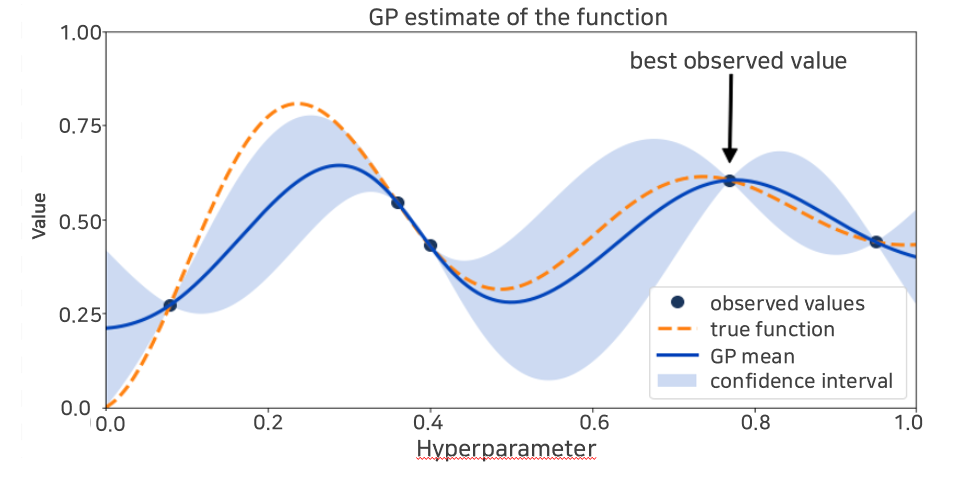

- step3
    - 추정된 최적 함수를 기반으로 획득 함수는 다음으로 관측할 하이퍼파라미터 값을 계산
    - 이전의 최적 관측값보다 더 큰 최대값을 가질 가능성이 높은 지점의 하이퍼파라미터를 대체 모델에 전달



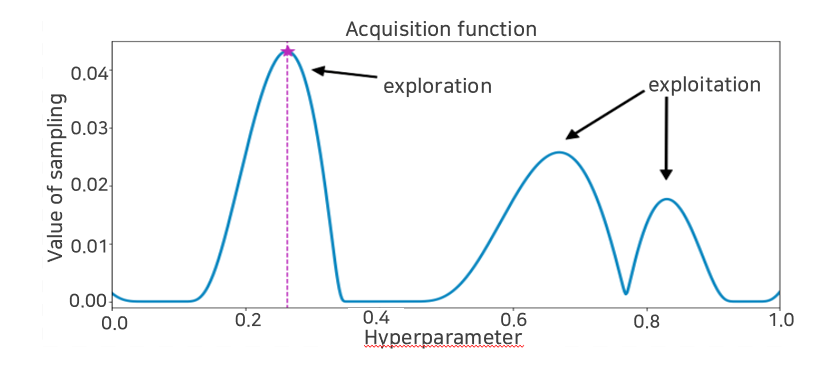

- step4
    - 획득 함수로부터 샘플링된 하이퍼파라미터를 수행하여 관측된 값을 기반으로 대체모델은 갱신되어 다시 최적 함수를 추정
    - Step 3와 Step 4를 지정한 횟수만큼 반복


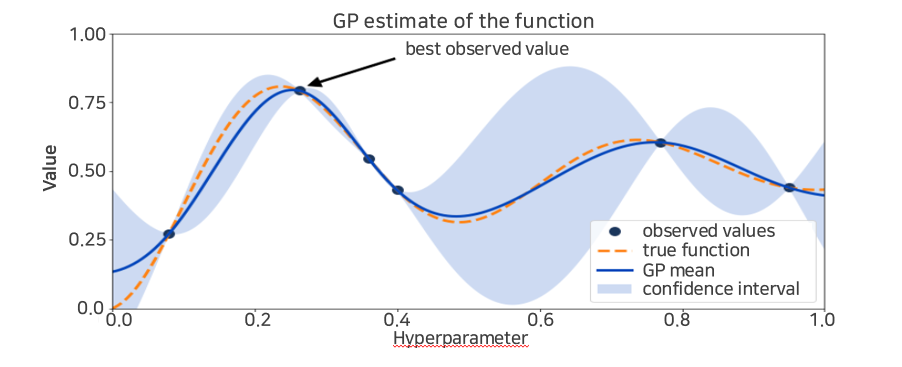

## optuna
- 베이지안 최적화 방식의 하이퍼파라미터 튜닝을 적용할 수 있는 파이썬 라이브러리
- https://optuna.readthedocs.io/en/stable/index.html
- 설치 방법
```python
pip install optuna
```

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.4 MB/s eta 0:00:00


## optuna 를 이용한 모델 튜닝 방법
1. 목적함수 생성
    - optuna 라이브러리는 목적함수에 trial 객체를 전달
    - trial 객체의 suggest 메서드 이용해서 하이퍼파라미터 세팅
        > trial 객체의 suggest 메서드가 사전지식을 반영하여 하이퍼파라미터 제안
    - 모델 학습 및 검증평가 결과 반환
2. 대체모델역할을 하는 Sampler 객체 생성
3. 전체적인 튜닝 과정을 수행하는 study 객체 생성 및 optimize 메서드 실행하여 튜닝

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
optuna.trial.Trial.suggest_int

<function optuna.trial._trial.Trial.suggest_int(self, name: 'str', low: 'int', high: 'int', *, step: 'int' = 1, log: 'bool' = False) -> 'int'>

In [ ]:
optuna.trial.Trial.suggest_float

<function optuna.trial._trial.Trial.suggest_float(self, name: 'str', low: 'float', high: 'float', *, step: 'float | None' = None, log: 'bool' = False) -> 'float'>

In [ ]:
optuna.trial.Trial.suggest_categorical

<function optuna.trial._trial.Trial.suggest_categorical(self, name: 'str', choices: 'Sequence[CategoricalChoiceType]') -> 'CategoricalChoiceType'>

In [ ]:
def objective(trial):
    hp = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 250),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "max_features": trial.suggest_float("max_features", 0.6, 1.0, step=0.05)
    }

    cv = KFold(5, shuffle=True, random_state=SEED)
    model = RandomForestClassifier(**hp, random_state=SEED)
    score = cross_val_score(model, train_ft, target, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED) # 대체모델역할을 하는 sampler 객체

# 스터디 객체
study = optuna.create_study(
    direction="maximize", # 평가지표에 따라 다르게 전달, minimize
    sampler=sampler
)

study.optimize(objective, n_trials=50) # 튜닝 수행

[I 2024-10-28 03:08:02,471] A new study created in memory with name: no-name-4ba79093-893d-4473-8375-c7a39e13c186
[I 2024-10-28 03:08:05,781] Trial 0 finished with value: 0.9022575538714955 and parameters: {'n_estimators': 144, 'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 4, 'max_features': 0.65}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:08:08,710] Trial 1 finished with value: 0.8974426080936834 and parameters: {'n_estimators': 89, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'max_features': 1.0}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:08:11,230] Trial 2 finished with value: 0.9120626184253464 and parameters: {'n_estimators': 222, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 7, 'max_features': 0.8}. Best is trial 2 with value: 0.9120626184253464.
[I 2024-10-28 03:08:12,640] Trial 3 finished with value: 0.9162605366657463 and parameters: {'n_estimators': 153, 'criterion': 'entropy', 'max_depth'

In [ ]:
study.best_value

0.9162605366657463

In [ ]:
study.best_trial.params

{'n_estimators': 153,
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_split': 7,
 'max_features': 0.75}

- 람다함수 사용한 예시

In [ ]:
def objective(trial, x, y, seed):
    hp = {
        "n_estimators": trial.suggest_int("n_estimators", 80, 250),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "max_features": trial.suggest_float("max_features", 0.6, 1.0, step=0.05)
    }

    cv = KFold(5, shuffle=True, random_state=seed)
    model = RandomForestClassifier(**hp, random_state=seed)
    score = cross_val_score(model, x, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()

    return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED) # 대체모델역할을 하는 sampler 객체

# 스터디 객체
study = optuna.create_study(
    direction="maximize", # 평가지표에 따라 다르게 전달, minimize
    sampler=sampler
)

objective_func = lambda trial: objective(trial, train_ft, target, SEED)

study.optimize(objective_func, n_trials=50) # 튜닝 수행

[I 2024-10-28 03:16:12,404] A new study created in memory with name: no-name-8d5f98a5-4686-45b9-8172-47317a617de7
[I 2024-10-28 03:16:17,763] Trial 0 finished with value: 0.9022575538714955 and parameters: {'n_estimators': 144, 'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 4, 'max_features': 0.65}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:16:18,813] Trial 1 finished with value: 0.8974426080936834 and parameters: {'n_estimators': 89, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'max_features': 1.0}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:16:20,802] Trial 2 finished with value: 0.9120626184253464 and parameters: {'n_estimators': 222, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 7, 'max_features': 0.8}. Best is trial 2 with value: 0.9120626184253464.
[I 2024-10-28 03:16:22,224] Trial 3 finished with value: 0.9162605366657463 and parameters: {'n_estimators': 153, 'criterion': 'entropy', 'max_depth'

- 클래스로 만드는 예시

In [ ]:
class Objective:
    def __init__(self, x, y, seed):
        self.x = x
        self.y = y
        self.seed = seed
        self.cv = KFold(5, shuffle=True, random_state=self.seed)

    def __call__(self, trial):
        hp = {
            "n_estimators": trial.suggest_int("n_estimators", 80, 250),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "max_features": trial.suggest_float("max_features", 0.6, 1.0, step=0.05)
        }
        model = RandomForestClassifier(**hp, random_state=self.seed)
        score = cross_val_score(model, self.x, self.y, cv=self.cv, scoring="roc_auc", n_jobs=-1).mean()

        return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED) # 대체모델역할을 하는 sampler 객체

# 스터디 객체
study = optuna.create_study(
    direction="maximize", # 평가지표에 따라 다르게 전달, minimize
    sampler=sampler
)

objective_func = Objective(train_ft, target, SEED)

study.optimize(objective_func, n_trials=50) # 튜닝 수행

[I 2024-10-28 03:26:37,022] A new study created in memory with name: no-name-cbf11f6f-c952-481c-b8e4-8b10a1e0c705
[I 2024-10-28 03:26:44,648] Trial 0 finished with value: 0.9022575538714955 and parameters: {'n_estimators': 144, 'criterion': 'gini', 'max_depth': 14, 'min_samples_split': 4, 'max_features': 0.65}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:26:46,158] Trial 1 finished with value: 0.8974426080936834 and parameters: {'n_estimators': 89, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 2, 'max_features': 1.0}. Best is trial 0 with value: 0.9022575538714955.
[I 2024-10-28 03:26:49,660] Trial 2 finished with value: 0.9120626184253464 and parameters: {'n_estimators': 222, 'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 7, 'max_features': 0.8}. Best is trial 2 with value: 0.9120626184253464.
[I 2024-10-28 03:26:51,395] Trial 3 finished with value: 0.9162605366657463 and parameters: {'n_estimators': 153, 'criterion': 'entropy', 'max_depth'

- 하이퍼파라미터 중요도 시각화

In [ ]:
optuna.visualization.plot_param_importances(study)

- 탐색과정에서 cv 점수에 대한 히스토리

In [ ]:
optuna.visualization.plot_optimization_history(study)

- 테스트 데이터 예측 수행하기

In [ ]:
study.best_params

{'n_estimators': 153,
 'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_split': 7,
 'max_features': 0.75}

In [ ]:
model = RandomForestClassifier(**study.best_params, random_state=SEED)
model.fit(train_ft, target)

RandomForestClassifier(criterion='entropy', max_depth=7, max_features=0.75,
                       min_samples_split=7, n_estimators=153, random_state=42)

In [ ]:
model.predict_proba(test_ft)

array([[8.02030896e-01, 1.97969104e-01],
       [7.75413696e-01, 2.24586304e-01],
       [9.60175865e-01, 3.98241350e-02],
       [1.35667216e-01, 8.64332784e-01],
       [1.52897263e-01, 8.47102737e-01],
       [4.82999704e-01, 5.17000296e-01],
       [8.99041422e-01, 1.00958578e-01],
       [7.88833140e-01, 2.11166860e-01],
       [3.62362215e-01, 6.37637785e-01],
       [1.14531341e-01, 8.85468659e-01],
       [9.43034619e-01, 5.69653808e-02],
       [1.61531238e-01, 8.38468762e-01],
       [1.67247677e-01, 8.32752323e-01],
       [3.55582733e-02, 9.64441727e-01],
       [4.67205673e-01, 5.32794327e-01],
       [9.18231255e-01, 8.17687448e-02],
       [9.37041718e-01, 6.29582819e-02],
       [9.86154537e-01, 1.38454627e-02],
       [8.72756510e-03, 9.91272435e-01],
       [9.36748640e-01, 6.32513604e-02],
       [8.73379974e-01, 1.26620026e-01],
       [8.63151497e-01, 1.36848503e-01],
       [1.69008093e-01, 8.30991907e-01],
       [9.34322307e-01, 6.56776933e-02],
       [9.004768